# Dynamical inter-subjects correlation (figure 2)

### Importing functions

In [1]:
import matplotlib as mpl
import h5py
import mne
import numpy as np
import scipy.stats as stats
import scipy
import pandas as pd
from os.path import join as pjoin
from itertools import product
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import colors
import matplotlib.cm as cm
import random
import os
import pickle
import warnings 
import matplotlib
from lempel_ziv_complexity import lempel_ziv_complexity
import seaborn as sns

import saving as sv
import avalanches as av
import Utils_FC as fc

warnings.simplefilter('ignore')

#path='/home/jeremy/anaconda3/matteo/'
path='C:/Users/matte/OneDrive/Documenti/matteo/'
#CREATING THE LIST OF SUBJECTS

#main definition:

sound_list=['speech','music', 'rest']

#colors for plotting 
col_s='#8CCC94'
col_m='#FCAC74'
col_r='#6CA4CC'

colors={}
colors['rest'] = '#6CA4CC'
colors['speech'] = '#8CCC94'
colors['music'] = '#FCAC74'

Computation subject list 

In [2]:

sound_list=['rest','music','speech']
arr_mu = os.listdir(path +'seeg_fif_data/music')
arr_rest = os.listdir(path +'seeg_fif_data/speech')
arr_speech = os.listdir(path +'seeg_fif_data/rest')

subject_set_mu=set()
subject_set_speech=set()
subject_set_rest=set()

for st in arr_mu: 
    #print(st)
    subject_set_mu.add(st.partition('_')[0])
    #print(st.partition('_')[0])
    
for st in arr_speech:
    subject_set_speech.add(st.partition('_')[0])
    
for st in arr_rest:
    subject_set_rest.add(st.partition('_')[0])

subject_list=list(subject_set_mu.intersection(subject_set_speech,subject_set_rest))

#Here I create a set of the  all channels
total_channels_set=set()

for subject in subject_list:
    with h5py.File(pjoin(path +'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
        #print(f.keys())
        #print('chnames', f['chnames'].shape)
        
        chnames = f['chnames'][...].astype('U')
        total_channels_set.update(chnames)
        
#print(total_channels_set)


#Here I create a set of the H channels
ch_H=set()
for ch in total_channels_set:
    
    if "H" in ch:
        ch_H.add(ch)

#Here I create another set of channels        
ch_IM=set()
for ch in total_channels_set:
    
    if "IP" in ch:
        ch_IM.add(ch)
#print(ch_H)





### Uploading data, channels and subject list

In [3]:
ch_H_i={}
zdata={}
for isub, subject in enumerate(subject_list):
    print(subject)
    zdata[subject]={}
    
    
    with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
        #print(f.keys())
        #print('chnames', f['chnames'].shape)

        chnames = f['chnames'][...].astype('U')
        x=f['chlocs']

    #Here we load the list of bad channels
    with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
        #print(f.keys())
        #print('outlier_chans', f['outlier_chans']['strict_bads_names'])

        bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
        #mu_bad_epo = f['outlier_epochs']['music']['strict_bads_epochs'][...]
        #sp_bad_epo = f['outlier_epochs']['speech']['strict_bads_epochs'][...]

    ## Cleaning from artifacts
    #List of bad channels indices
    ch_i = [i for i, ch in enumerate(chnames) if ch in bad_chans]

    clean_chnames = [ch for i, ch in enumerate(chnames) if ch not in bad_chans]
    ch_H_i[subject]= [i for i, ch in enumerate(clean_chnames) if ch in ch_H]
    
    print(ch_H_i[subject])
    
sv.saving(ch_H_i, path+"H_channels_indices_subjects")
    
    

sub-28e70e7c7fbb
[9, 10, 11, 12, 13, 14, 108, 109, 110, 111, 112, 113, 114, 115, 116]
sub-c2a96116ddc4
[87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
sub-14c725b6b803
[29, 30, 31, 32, 33, 34, 35, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93]
sub-44375d501493
[100, 101, 102, 103, 104, 105, 106]
sub-82e330f8aadd
[30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
sub-45a6830d263e
[55, 56, 57, 58, 59, 60, 61, 62, 63]
sub-cacae171ee15
[28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 86, 87, 88, 89, 90, 91, 92, 93, 94]
sub-3ef8645f99c5
[88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
sub-83ebd5328120
[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
sub-26176ef8a8d0
[32, 33, 34, 35, 36, 37, 38, 39, 66, 67, 68, 69, 70, 71, 72]
sub-a4e7fc9daa96
[51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]
sub-4247d6d6cdbf
[31, 32, 33, 34, 35, 36, 37, 38, 39, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]
sub-9d783b836

In [4]:

#PARAMETERS

dataused=''

subject_list=subject_list

final_channels_without_H={}

final_channels_H={}

final_channels_all={}

dataused='without_H'

datatipe="hgenv_down100"

zdata={}

ch_H_i={}
for isub, subject in enumerate(subject_list):
    
    zdata[subject]={}
    
    for sound in sound_list:
    
        ## Load the data from the HDF fil
        #print(subject, isub)    
        #Loading the data
        with h5py.File(pjoin(path+'seeg_data_hgenv_down100_h5py/', subject + '_down100_seeg_preproc.hdf5'), 'r') as f:
            #print(f.keys())
            #print('music', f['music'].shape)

            #data_music[subject]=f['music'][...]
            data_raw=f[sound][...]
            
            #Here we delete the time point of the rest that correspond to the end and beginning of the three sessions
            if sound=='rest':
                index_del=np.concatenate((np.arange(int(len(data_raw[0,:])/3)-200,int(len(data_raw[0,:])/3)+200),np.arange(int(len(data_raw[0,:])*2/3)-200,int(len(data_raw[0,:])*2/3)+200)))   
                data_raw=np.delete(data_raw, index_del, axis=1)

            data_raw=data_raw[:,100:-100]

        #Here we load the channels names
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
            #print(f.keys())
            #print('chnames', f['chnames'].shape)

            chnames = f['chnames'][...].astype('U')
            x=f['chlocs']

        #Here we load the list of bad channels
        with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
            #print(f.keys())
            #print('outlier_chans', f['outlier_chans']['strict_bads_names'])

            bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
            #mu_bad_epo = f['outlier_epochs']['music']['strict_bads_epochs'][...]
            #sp_bad_epo = f['outlier_epochs']['speech']['strict_bads_epochs'][...]

        ## Cleaning from artifacts
        #List of bad channels indices
        ch_i = [i for i, ch in enumerate(chnames) if ch in bad_chans]

        clean_chnames = [ch for i, ch in enumerate(chnames) if ch not in bad_chans]

        clean= np.delete(data_raw, ch_i, axis=0)

        #List of indices of H channels, list of indices of not H channels
        ch_H_i[subject]= [i for i, ch in enumerate(clean_chnames) if ch not in ch_H]
        ch_H_w_i= [i for i, ch in enumerate(clean_chnames) if ch in ch_H]

        #dictionaries with subjects ad keys and channels names
        final_channels_without_H[subject]=[ch for i, ch in enumerate(clean_chnames) if i in ch_H_i[subject]]
        final_channels_H[subject]=[ch for i, ch in enumerate(clean_chnames) if i not in ch_H_i[subject]]
        final_channels_all[subject]=clean_chnames

        #The final channels that we used
        final_channels=clean_chnames


        #HERE WE CREATE THE DATA SET, THAT WE USE
        #only the channels in Helsch gyrus
        clean_H = np.delete(clean, ch_H_i[subject], axis=0)

        #only the channels not in the helsch gyrus
        clean_without_H = np.delete(clean, ch_H_w_i, axis=0)

        #clean_mu=clean2(clean_music_H, N=3)
        #clean_sp=clean2(clean_speech_H, N=3)
        #clean_re=clean2(clean_rest_H, N=3)

        #zscore of the data
        zdata_art=stats.zscore(clean, axis=1)

        #the artifacts are substituted by 0
        zdata_=np.where(np.abs(zdata_art)>5, 0, zdata_art)

        
        #zscored computed again
        zdata[subject][sound]=stats.zscore(zdata_, axis=1)
    
#sv.saving(zdata, path+"data_subject_sound_" + datatipe)
#sv.saving(ch_H_i, path+"H_channels_indices_subjects")
        if subject==  'sub-e0bb6ccef2a5':
            print(zdata[subject][sound].shape)


(110, 56670)
(110, 57837)
(110, 57470)


In [5]:
#datatipe="hgenv_down100"
ap={} #here the activity profile of each subject is stored
#data=sv.loading( path+"data_subject_sound_" + datatipe)
for subject in subject_list:
    ap[subject]={}
    avalanches={}
    
    #the threshold is derived as the 99th percentile of the data
    thres=np.percentile(zdata[subject]['rest'], 99)
    print(thres)
    
    for sound in sound_list:
        
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches[sound]=av.go_avalanches(zdata[subject][sound].T, thre=thres, direc=0, binsize=2)

        ap[subject][sound]=np.sum(avalanches[sound]['Zbin'].T, axis=0)
        

2.803148765547773
2.7985919037396925
2.7507264122036497
2.897258743666651
3.334984151824247
2.8138171563785437
2.734310175019014
2.818625307029934
2.8089245753814596
2.79738475441734
2.7742837529435107
2.7761437719778965
2.7654285000333187
2.8552720483703933
2.774284818922206
2.9744978125454247
2.7331326834817284
2.78534246404477
2.750861898649132


Here we create a matrix, whose lines are ap of different subjects

In [6]:

ap_matrix={} 
for sound in sound_list:
    ap_matrix[sound]=np.zeros((len(subject_list), len(ap[subject_list[0]][sound])))
    for isub, subject in enumerate(subject_list):
        ap_matrix[sound][isub,:]=ap[subject][sound]
    

## COMPUTING THE DYNAMICAL CORREALTION

In [7]:


window_length=50
time_interval=1
dcorr=dict()
dcorr_matrix={}
dcorr_all={}

#computations
for sound in sound_list:
    dcorr[sound]={}
    dcorr_matrix[sound]=[]
    mat=[]
    
    for isub, subject in enumerate(subject_list):
        dcorr[sound][subject]=[]
        
        for i in np.arange(0,len(ap_matrix[sound][0,:])-window_length, time_interval):
            dcorr[sound][subject].append(np.sum((np.corrcoef(ap_matrix[sound][:,i:i+window_length])-np.identity(19))[isub,:])/18)
        
        #print(len(dcorr[sound][subject]))
        mat.append(dcorr[sound][subject])
        
    dcorr_matrix[sound]=np.array(mat)
    dcorr_all[sound]=np.mean(np.array(mat), axis=0)
    #print('la lunghezza è', dcorr_matrix[sound].shape)

The correlation is saved as dcorr_all_windowlength_timeinterval

In [11]:
sv.saving(dcorr_all, path+'dcorr_all_'+str(window_length)'_1')

SyntaxError: invalid syntax (2760878878.py, line 1)

Plotting the dynamical correlation, in a couple of subjects x time fashion.

No handles with labels found to put in legend.


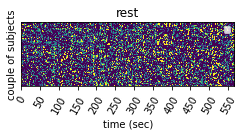

No handles with labels found to put in legend.


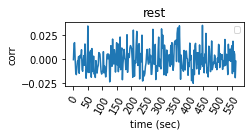

No handles with labels found to put in legend.


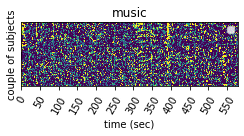

No handles with labels found to put in legend.


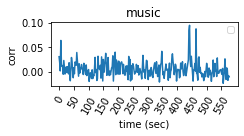

No handles with labels found to put in legend.


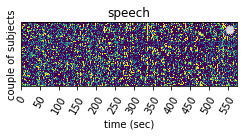

No handles with labels found to put in legend.


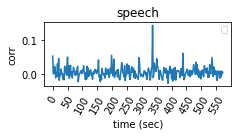

In [107]:
for sound in sound_list:
    
    edge=fc.go_edge(ap_matrix[sound].T)
    #plotting
    plt.figure(figsize=(3.5,2))
    plt.imshow(edge.T, aspect='auto', vmin=a, vmax=b)
    plt.xticks(np.arange(0,len(edge[:,0]),2500), np.arange(0,int(len(edge[:,0])/50),50), rotation=60, fontsize=10 )
    plt.yticks([])
    plt.xlabel('time (sec)', fontsize=10)
    plt.ylabel('couple of subjects', fontsize=10)
    plt.legend(fontsize=8)
    plt.title(sound)
    plt.tight_layout()
    plt.savefig(path+'figure/dynamical_correlation_across_subject_'+sound+'_'+dataused+'.png', dpi=600)
    plt.show()
    plt.close()
    
    
    plt.figure(figsize=(3.5,2))
    plt.plot(dcorr_all[sound][::100])
    plt.xticks(np.arange(0,len(dcorr_all[sound][::100]),25), np.arange(0,len(dcorr_all[sound][::50]),50), rotation=60, fontsize=10)
    plt.xlabel('time (sec)', fontsize=10)
    plt.ylabel('corr', fontsize=10)
    plt.legend(fontsize=8)
    plt.title(sound)
    plt.tight_layout()
    plt.savefig(path+'figure/dynamical_correlation_'+sound+'_'+dataused+'.png', dpi=600)
    plt.show()
    plt.close()
    


In [ ]:
window_length=50
time_interval=1

dcorr_all=sv.loading(path+'dcorr_all_'+str(window_length)+'_'+str(time_interval))


ind_all={}

for sound in sound_list:
    
    #corr_thres_l=np.percentile(dcorr_all[sound], 98)
    corr_thres_l=max(dcorr_all['rest'])
    
    aa=set(np.where(dcorr_all[sound]>corr_thres_l)[0])
    #bb=set(np.where(dcorr_all[sound]<corr_thres_h)[0])
    ind_all[sound]=list(aa)
    print(len(aa))
    #In the following line a different methdod per subject was studied
    """for subject in subject_list:
    
        corr_thres=np.percentile(dcorr[sound][subject], 99)

        ind[sound][subject]=np.where(dcorr[sound][subject]>corr_thres)[0]"""

0
397
212


In [ ]:
index_all=dict()
for sound in sound_list:
    
    aall=set()
    for i in ind_all[sound]:
        aall.update(np.arange(i,i+window_length))
            
    index_all[sound]=list(aall)

mem={}
m=min(len(index_all['speech']), len(index_all['music']))
print(len(index_all['speech']), len(index_all['music']), len(index_all['rest']))
for sound in ['speech', 'music', 'rest']:
    #index_all[sound]=index_all[sound][:m]
    mem[sound]=len(index_all[sound])


824 982 0


## here I compute the engagement for speech and music for those instant of time in which the inter-subject correlation was higher than the 98 percentile.

In [ ]:
datatipe='hgenv_down100'
#data=sv.loading( path+"data_subject_sound_"+datatipe) #loading the data of the three conditions that we saved before 

eng_simple={}
lenn={}
for sound in sound_list:
    
    eng_simple[sound]={}
    lenn[sound]={}
    for subject in subject_list:
        #zdata=data[subject]  #loading the data of the three conditions that we saved before 

        #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(zdata[subject]['rest'], 99)
        #print(thres)        
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches=av.go_avalanches(zdata[subject][sound].T, thre=thres, direc=0, binsize=2)
        lenn[sound][subject]=len(avalanches['Zbin'][:,0])
        aval=avalanches['Zbin'][index_all[sound],:]
                                                           
        engagementt=np.sum(aval, axis=0)
        eng_simple[sound][subject]=engagementt
        
        
#sv.saving(eng_simple, 'simple_engagement')

In [ ]:
datatipe='hgenv_down100'
#data=sv.loading( path+"data_subject_sound_"+datatipe) #loading the data of the three conditions that we saved before 

eng_simpla={}

for sound in sound_list:
    
    eng_simpla[sound]={}
    
    for subject in subject_list:
        #zdata=data[subject]  #loading the data of the three conditions that we saved before 

        #the threshold is derived as the 99th percentile of the data
        thres=np.percentile(zdata[subject]['rest'], 99)
        #print(thres)        
        #avalanches dictionaries are computed using the functions of Utils_avalanches.py
        avalanches=av.go_avalanches(zdata[subject][sound].T, thre=thres, direc=0, binsize=2)
        
        aval=avalanches['Zbin']
                                                           
        engagementt=np.sum(aval, axis=0)
        eng_simpla[sound][subject]=engagementt
        
        
#sv.saving(eng_simple, 'simple_engagement')

## finally I plot the average engagement of the H-channels of the subejcts in the most correlated moments of the three conditions. 

In [ ]:
def p_eng(eng11,eng22,n1,n2):

    p1=np.zeros(len(eng11))
    p2=np.zeros(len(eng11))
    for i, aa in enumerate(zip(eng11,eng22)):
        eng1, eng2 = aa
        p=(eng1+eng2)/(n1+n2)
        k1=eng1
        k2=eng2
        p1[i] = scipy.stats.hypergeom.cdf(k1, n1+n2, eng1+eng2, n1)
        #scipy.stats.norm.cdf((k1-n1*p)/np.sqrt(n1*p*(1-p)))
        p2[i] = scipy.stats.hypergeom.cdf(k2, n1+n2, eng1+eng2, n2)
    return p1,p2

In [ ]:
peng_dyn={}
for sound in ['speech', 'music']:
    peng_dyn[sound]={}
    for sub in subject_list:
        peng_dyn[sound][sub]=p_eng(eng_simple[sound][sub], eng_simpla['rest'][sub], mem[sound], lenn['rest'][sub]) 



In [ ]:
for sound in ['speech_music']:
    peng_dyn[sound]={}
    for sub in subject_list:
        peng_dyn[sound][sub]=p_eng(eng_simple['speech'][sub], eng_simple['music'][sub], mem['speech'], mem['music']) 



In [ ]:
sv.saving(peng_dyn, 'peng_dyn_bins2')

In [ ]:
peng_dyn=sv.loading('peng_dyn_bins2')

In [ ]:
peng={}
for sound in ['speech', 'music']:
    peng[sound]={}
    for sub in subject_list:
        peng[sound][sub]=p_eng(eng_simpla[sound][sub], eng_simpla['rest'][sub], lenn[sound][sub], lenn['rest'][sub]) 


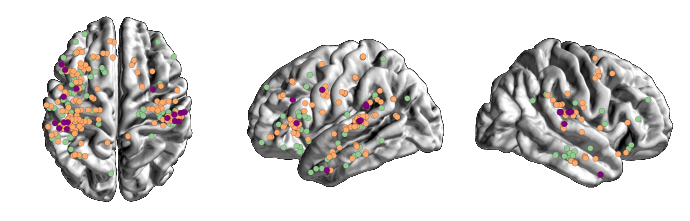

In [ ]:

alpha=1
edgecolors='k'
size=70
linewidths=0.1
p_value = 0.05
enga={}
for sound in ['speech','music', 'ixi']:
    enga[sound]={}
    for subject in subject_list:
        pp=p_value/len(peng_dyn['speech'][subject][0])
                       
        if sound=='ixi':
            enga[sound][subject]=np.where(peng_dyn['speech'][subject][0]>1-pp,1,0)*np.where(peng_dyn['music'][subject][0]>1-pp,1,0)

        
        else:
            
            enga[sound][subject]=np.where(peng_dyn[sound][subject][0]>1-pp,1,0)




C1 = {'s': '#93cb90', 'm': '#ffa96b', 'r': '#6da3cc', 'i':'purple'}

fig, ax= plt.subplots(1,3, figsize=(7,3))


for o, sound in enumerate(['speech','music','ixi']):
    for j, orientation in enumerate(['top','left','right']):

        
        axes=ax[j]
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        axes.spines['bottom'].set_visible(False)
        axes.spines['left'].set_visible(False)
      
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', 'mayavi_electrodes.hdf5'), 'r') as f:
            
            im = f[orientation]['imp'][...]
        
        for isub,subject in enumerate(subject_list):            
           
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
                #print(f.keys())
                #print('chnames', f['chnames'].shape)
        
                chnames = f['chnames'][...].astype('U')
                x=f['chlocs']
            
            
            with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
                #print(f.keys())
                #print('outlier_chans', f['outlier_chans']['strict_bads_names'])
    
                bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
        
            ch_i = [i for i, ch in enumerate(chnames) if ch not in bad_chans]
            
            chnames=chnames[ch_i]
            
            # collect coordinates for this specific orientation (only one patient)
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
                coordinates=f['mayavi'][orientation]['xy'][...]
                
            coordinates=coordinates[ch_i]
        
            # make sure you only select the left electrodes for the left orientation and
            # right electrodes for the right orientation
      
            
            if orientation in ('left', 'right'):
                
                _, _, left_i, right_i = mp.split_hemis(chnames)
                x_h = coordinates[left_i] if orientation == 'left' else coordinates[right_i]
                
                if orientation == 'left':
                    cmap=[]
                    for i in range(len(enga[sound][subject][left_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((enga[sound][subject][left_i]))[i,:]))
                
                if orientation == 'right':
                    cmap=[]
                    for i in range(len(enga[sound][subject][right_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((enga[sound][subject][right_i]))[i,:]))
                
                    
                    
            elif orientation == 'top':
                cmap=[]
                for i in range(len(enga[sound][subject])):
                    cmap.append(matplotlib.colors.rgb2hex(cm.bwr((enga[sound][subject]))[i,:]))
                x_h = coordinates
                
            color=C1[sound[:1]]
            axes.imshow(im)
            if orientation =='left':
                if left_i != []:
                    axes.scatter(*x_h.T, color=color, s=size*np.ones(len(x_h)), marker='.',edgecolors=edgecolors,linewidths=linewidths, alpha=(enga[sound][subject][left_i])*alpha)
                
            if orientation =='right':

                if right_i != []:
                    axes.scatter(*x_h.T, color=color, s=size*np.ones(len(x_h)), marker='.',edgecolors=edgecolors,linewidths=linewidths, alpha=(enga[sound][subject][right_i])*alpha)
                
            if orientation =='top':
                axes.scatter(*x_h.T, color=color, s=size*np.ones(len(x_h)), marker='.',edgecolors=edgecolors,linewidths=linewidths, alpha=(enga[sound][subject])*alpha)

                
            #axes.title.set_text('engagement '+sound)
            axes.set_xticks([])
            axes.set_yticks([])

    plt.subplots_adjust(wspace=None, hspace=None)
    plt.tight_layout()
    plt.savefig('brain_plot_p01_speechmusicvsrest_dyncorr_window50_slide1.png', dpi=600)


## here the same plot but considering all data

In [ ]:

alpha=1
edgecolors='k'
size=70
linewidths=0.1
p_value = 0.05
enga={}
for sound in ['speech','music', 'ixi']:
    enga[sound]={}
    for subject in subject_list:
        pp=p_value/len(peng_dyn['speech'][subject][0])
                       
        if sound=='ixi':
            enga[sound][subject]=np.where(peng_dyn['speech'][subject][0]>1-pp,1,0)*np.where(peng_dyn['music'][subject][0]>1-pp,1,0)

        
        else:
            
            enga[sound][subject]=np.where(peng_dyn[sound][subject][0]>1-pp,1,0)




C1 = {'s': '#93cb90', 'm': '#ffa96b', 'r': '#6da3cc', 'i':'purple'}

fig, ax= plt.subplots(1,3, figsize=(7,3))


for o, sound in enumerate(['speech','music','ixi']):
    for j, orientation in enumerate(['top','left','right']):

        
        axes=ax[j]
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        axes.spines['bottom'].set_visible(False)
        axes.spines['left'].set_visible(False)
      
        with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', 'mayavi_electrodes.hdf5'), 'r') as f:
            
            im = f[orientation]['imp'][...]
        
        for isub,subject in enumerate(subject_list):            
           
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
                #print(f.keys())
                #print('chnames', f['chnames'].shape)
        
                chnames = f['chnames'][...].astype('U')
                x=f['chlocs']
            
            
            with h5py.File(pjoin(path + 'seeg_data_h5py/h5_misc/', subject + '_misc.hdf5'), 'r') as f:
                #print(f.keys())
                #print('outlier_chans', f['outlier_chans']['strict_bads_names'])
    
                bad_chans = f['outlier_chans']['strict_bads_names'][...].astype('U')
        
            ch_i = [i for i, ch in enumerate(chnames) if ch not in bad_chans]
            
            chnames=chnames[ch_i]
            
            # collect coordinates for this specific orientation (only one patient)
            with h5py.File(pjoin(path+ 'seeg_data_h5py/h5_electrodes/', subject + '_electrodes.hdf5'), 'r') as f:
            
                coordinates=f['mayavi'][orientation]['xy'][...]
                
            coordinates=coordinates[ch_i]
        
            # make sure you only select the left electrodes for the left orientation and
            # right electrodes for the right orientation
      
            
            if orientation in ('left', 'right'):
                
                _, _, left_i, right_i = mp.split_hemis(chnames)
                x_h = coordinates[left_i] if orientation == 'left' else coordinates[right_i]
                
                if orientation == 'left':
                    cmap=[]
                    for i in range(len(enga[sound][subject][left_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((enga[sound][subject][left_i]))[i,:]))
                
                if orientation == 'right':
                    cmap=[]
                    for i in range(len(enga[sound][subject][right_i])):
                        cmap.append(matplotlib.colors.rgb2hex(cm.bwr((enga[sound][subject][right_i]))[i,:]))
                
                    
                    
            elif orientation == 'top':
                cmap=[]
                for i in range(len(enga[sound][subject])):
                    cmap.append(matplotlib.colors.rgb2hex(cm.bwr((enga[sound][subject]))[i,:]))
                x_h = coordinates
                
            color=C1[sound[:1]]
            axes.imshow(im)
            if orientation =='left':
                if left_i != []:
                    axes.scatter(*x_h.T, color=color, s=size*np.ones(len(x_h)), marker='.',edgecolors=edgecolors,linewidths=linewidths, alpha=(enga[sound][subject][left_i])*alpha)
                
            if orientation =='right':

                if right_i != []:
                    axes.scatter(*x_h.T, color=color, s=size*np.ones(len(x_h)), marker='.',edgecolors=edgecolors,linewidths=linewidths, alpha=(enga[sound][subject][right_i])*alpha)
                
            if orientation =='top':
                axes.scatter(*x_h.T, color=color, s=size*np.ones(len(x_h)), marker='.',edgecolors=edgecolors,linewidths=linewidths, alpha=(enga[sound][subject])*alpha)

                
            #axes.title.set_text('engagement '+sound)
            axes.set_xticks([])
            axes.set_yticks([])

    plt.subplots_adjust(wspace=None, hspace=None)
    plt.tight_layout()
    plt.savefig('brain_plot_p01_speechmusicvsrest_alldata_plotsmtog.png', dpi=600)


Unexpected exception formatting exception. Falling back to standard exception
Error in callback <function _draw_all_if_interactive at 0x000001C8B93DFA60> (for post_execute):


Traceback (most recent call last):
  File "C:\Users\matte\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3442, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\matte\AppData\Local\Temp\ipykernel_33892\326639821.py", line 97, in <module>
    axes.imshow(im)
  File "c:\Users\matte\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\_api\deprecation.py", line 454, in wrapper
    return func(*args, **kwargs)
  File "c:\Users\matte\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\__init__.py", line 1423, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
  File "c:\Users\matte\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\axes\_axes.py", line 5604, in imshow
    im.set_data(X)
  File "c:\Users\matte\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\image.py", line 697, in set_data
    self._A = cbook.safe_masked_invalid(A, cop

MemoryError: Unable to allocate 2.31 MiB for an array with shape (756, 800) and data type float32